In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import sys
# sys.path.insert(0, '../')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


import numpy as np
import tensorflow as tf

from gantools import data
from gantools import utils
from gantools import plot
from gantools.model import WGAN
from gantools.gansystem import GANsystem
from gantools.data import fmap
from gantools import evaluation
import functools
import matplotlib.pyplot as plt
from copy import deepcopy

# Parameters

In [3]:
ns = 64 # Resolution of the image
scaling = 16
try_resume = True

# Data handling

Load the data

In [4]:
dataset = data.load.load_maps_dataset(spix=ns, scaling=16, augmentation=True, patch=False)

images shape =  (200, 2304, 2560, 3)


In [5]:
# The dataset can return an iterator.
it = dataset.iter(10)
print(next(it).shape)
del it

(10, 64, 64, 3)


In [6]:
# Get all the data
X = dataset.get_all_data().flatten()

Display the histogram of the pixel densities after the forward map

min: 0.00784289836883545
max: 0.9961089491844177


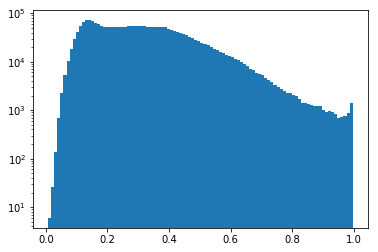

In [7]:
plt.hist(X, 100)
print('min: {}'.format(np.min(X)))
print('max: {}'.format(np.max(X)))
plt.yscale('log')

In [8]:
# to free some memory
del X

Let us plot 16 images

Text(0.5,1,'Real samples')

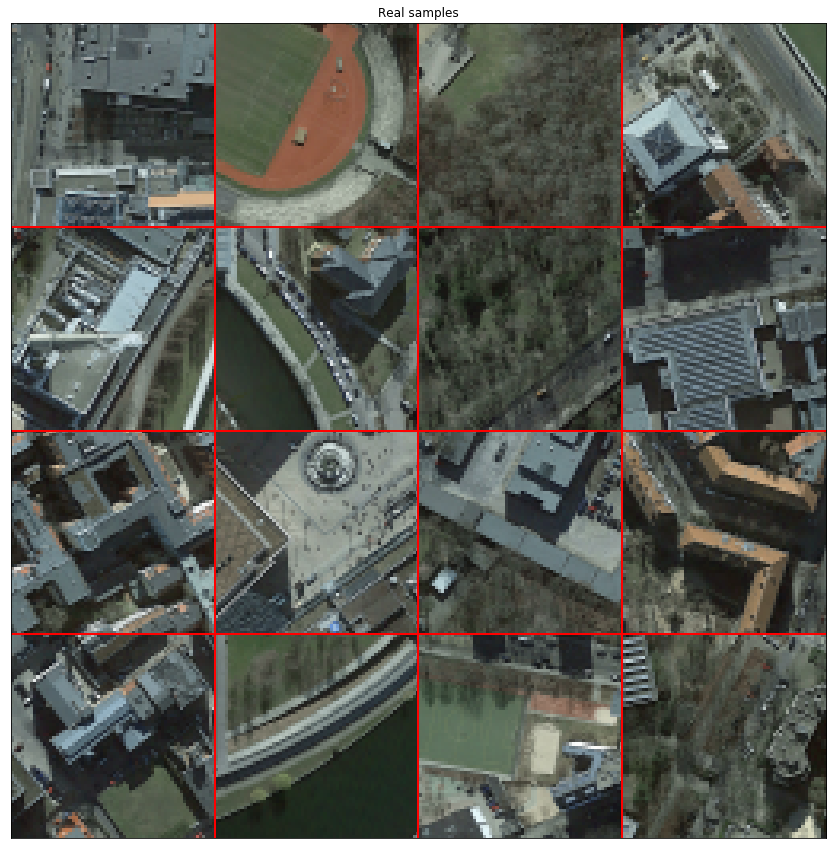

In [9]:
plt.figure(figsize=(15,15))
plot.draw_images(dataset.get_samples(N=16),nx=4,ny=4);
plt.title("Real samples")

# Define parameters for the WGAN

In [33]:
time_str = 'maps_balanced_normalized'.format(scaling)
global_path = '../saved_results'

name = 'WGAN{}'.format(ns) + '_' + time_str

## Parameters

In [34]:
bn = False

def non_lin(x):
    return (tf.nn.tanh(x) + 1.0)/2.0

md=32

params_discriminator = dict()
params_discriminator['stride'] = [1, 2, 2, 2, 2]
params_discriminator['nfilter'] = [md, md, 4*md, 16*md, 64*md]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5], [5, 5], [5, 5]]
params_discriminator['batch_norm'] = [bn, bn, bn, bn, bn]
params_discriminator['full'] = [100]
params_discriminator['minibatch_reg'] = False
params_discriminator['summary'] = True
params_discriminator['data_size'] = 2
params_discriminator['inception'] = False
params_discriminator['spectral_norm'] = True

params_generator = dict()
params_generator['stride'] = [2, 2, 2, 2, 1]
params_generator['latent_dim'] = 100
params_generator['nfilter'] = [64*md, 16*md, 4*md, md, 3]
params_generator['shape'] = [[3, 3], [5, 5],[5, 5], [5, 5],[5, 5],[5, 5]]
params_generator['batch_norm'] = [bn, bn, bn, bn]
params_generator['full'] = [4*4*64*md]
params_generator['summary'] = True
params_generator['non_lin'] = non_lin
params_generator['data_size'] = 2
params_generator['inception'] = False
params_generator['spectral_norm'] = True

params_optimization = dict()
params_optimization['batch_size'] = 32
params_optimization['epoch'] = 10000
params_optimization['n_critic'] = 5
# params_optimization['generator'] = dict()
# params_optimization['generator']['optimizer'] = 'adam'
# params_optimization['generator']['kwargs'] = {'beta1':0, 'beta2':0.9}
# params_optimization['generator']['learning_rate'] = 0.0004
# params_optimization['discriminator'] = dict()
# params_optimization['discriminator']['optimizer'] = 'adam'
# params_optimization['discriminator']['kwargs'] = {'beta1':0, 'beta2':0.9}
# params_optimization['discriminator']['learning_rate'] = 0.0001


# all parameters
params = dict()
params['net'] = dict() # All the parameters for the model
params['net']['generator'] = params_generator
params['net']['discriminator'] = params_discriminator
params['net']['prior_distribution'] = 'gaussian'
params['net']['shape'] = [ns, ns, 3] # Shape of the image
params['net']['gamma_gp'] = 10 # Gradient penalty
params['net']['upsampling'] = None 
params['net']['loss_type'] = 'normalized_wasserstein' 

params['optimization'] = params_optimization
params['summary_every'] = 100 # Tensorboard summaries every ** iterations
params['print_every'] = 50 # Console summaries every ** iterations
params['save_every'] = 1000 # Save the model every ** iterations
params['summary_dir'] = os.path.join(global_path, name +'_summary/')
params['save_dir'] = os.path.join(global_path, name + '_checkpoints/')
params['Nstats'] = 10

resume, params = utils.test_resume(try_resume, params)
params['optimization']['epoch'] = 100000
params['save_every'] = 5000 # Save the model every ** iterations


No resume, the training will start from the beginning!


# Build the model

In [35]:
wgan = GANsystem(WGAN, params)

Generator 
--------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 32768 outputs
         Size of the variables: (?, 32768)
     Reshape to (?, 4, 4, 2048)
     1 Deconv layer with 2048 channels
         Non linearity applied
         Size of the variables: (?, 8, 8, 2048)
     2 Deconv layer with 512 channels
         Non linearity applied
         Size of the variables: (?, 16, 16, 512)
     3 Deconv layer with 128 channels
         Non linearity applied
         Size of the variables: (?, 32, 32, 128)
     4 Deconv layer with 32 channels
         Non linearity applied
         Size of the variables: (?, 64, 64, 32)
     5 Deconv layer with 3 channels
         Size of the variables: (?, 64, 64, 3)
    Costum non linearity: <function non_lin at 0x7f40b0bd8268>
     The output is of size (?, 64, 64, 3)
--------------------------------------------------

Discriminator 
--------------------------------------------------
     The input 

# Train the model

In [ ]:
wgan.train(dataset, resume=resume)

Compute real statistics: descriptives/mean_l2
Compute real statistics: descriptives/var_l2
Compute real statistics: descriptives/min_l2
Compute real statistics: descriptives/max_l2
Compute real statistics: descriptives/kurtosis_l2
Compute real statistics: descriptives/skewness_l2
Compute real statistics: descriptives/median_l2
Erase recursively directory: ../saved_results/WGAN64_maps_balanced_normalized_checkpoints/
Start training
 * Epoch: [ 8] [   2/   6] Counter:50	( 1.3 min	20.695 examples/sec	1.55 sec/batch)
   Disc batch loss:-2.36291170	Disc epoch loss:-2.54996085
   Gen batch loss:1.89755583	Gen epoch loss:2.33949375
 * Epoch: [16] [   4/   6] Counter:100	( 2.6 min	20.794 examples/sec	1.54 sec/batch)
   Disc batch loss:-3.66529465	Disc epoch loss:-3.56474984
   Gen batch loss:4.16074657	Gen epoch loss:3.42919093
 * Epoch: [24] [   6/   6] Counter:150	( 3.9 min	19.826 examples/sec	1.61 sec/batch)
   Disc batch loss:-3.07944727	Disc epoch loss:-3.30139709
   Gen batch loss:2.6485

# Generate new samples
To have meaningful statistics, be sure to generate enough samples
* 2000 : 32 x 32
* 500 : 64 x 64
* 200 : 128 x 128


In [31]:
N = 200 # Number of samples
gen_sample = np.squeeze(wgan.generate(N=N))

Sampling z
 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../saved_results/WGAN64_maps_balanced_checkpoints/wgan-648736
Checkpoint succesfully loaded!


Display a few fake samples

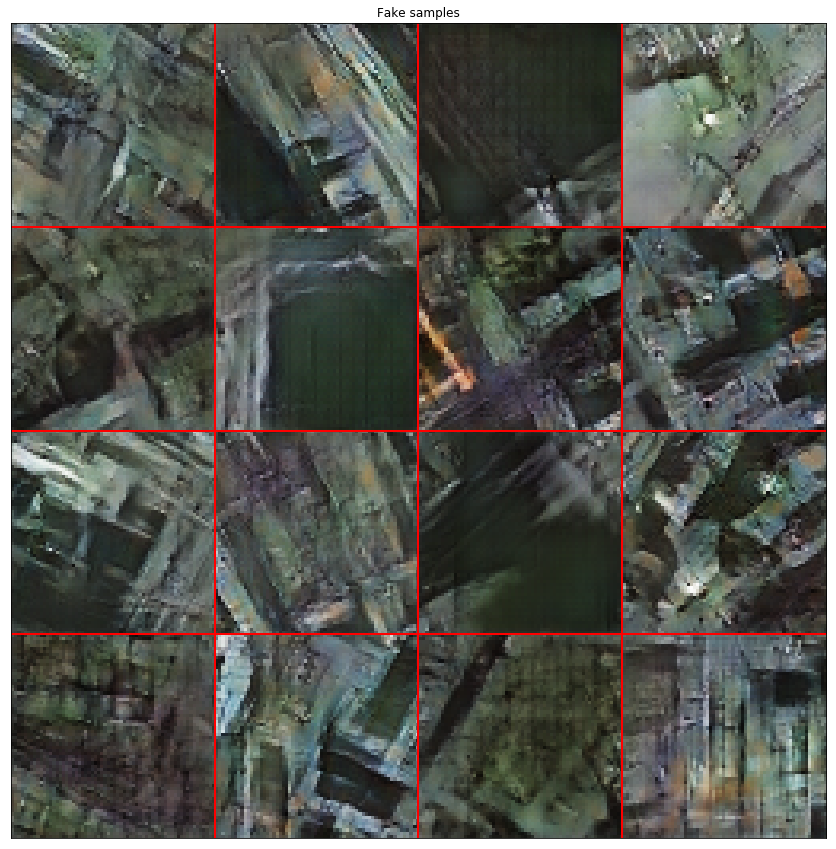

In [32]:
plt.figure(figsize=(15,15))
plot.draw_images(gen_sample,nx=4,ny=4);
plt.title("Fake samples");